# Binary classification
---------------------------------

This example shows how we can use ATOM to perform a variety of data cleaning steps in order to prepare the data for modelling. Then, we compare the performances of two tree-based models.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
119416,Perth,10.8,20.0,0.0,2.2,9.2,N,31.0
106911,Albany,7.7,21.0,6.4,3.4,8.3,NaN,NaN
7934,Cobar,9.9,23.6,0.0,5.4,NaN,ENE,37.0
60207,Sale,10.3,26.0,0.0,3.2,8.5,E,31.0
141829,Uluru,8.8,11.3,0.6,NaN,NaN,E,35.0


## Run the pipeline

In [3]:
# Call ATOM using only 5% of the complete dataset (for explanatory purposes)
atom = ATOMClassifier(X, 'RainTomorrow', n_rows=0.05, n_jobs=8, warnings=False, verbose=2, random_state=1)

<< ================== ATOM ================== >>
Algorithm task: binary classification.
Parallel processing with 8 cores.

Dataset stats ================== >>
Shape: (7110, 22)
Missing values: 15896
Categorical columns: 5
Scaled: False
-----------------------------------
Train set size: 5688
Test set size: 1422
-----------------------------------
Train set balance: No:Yes <==> 1.0:3.7
Test set balance: No:Yes <==> 1.0:4.1
-----------------------------------
Distribution of classes:
|     |   dataset |   train |   test |
|:----|----------:|--------:|-------:|
| No  |      1495 |    1215 |    280 |
| Yes |      5615 |    4473 |   1142 |



In [4]:
# Encode the target column
atom.clean()

Applying data cleaning...
 --> Label-encoding the target column.


In [5]:
# Impute missing values
atom.impute(strat_num='knn', strat_cat='drop', min_frac_rows=0.8)

Imputing missing values...
 --> Dropping 774 rows for containing less than 80% non-missing values.
 --> Imputing 7 missing values using the KNN imputer in feature MinTemp.
 --> Imputing 5 missing values using the KNN imputer in feature MaxTemp.
 --> Imputing 33 missing values using the KNN imputer in feature Rainfall.
 --> Imputing 2315 missing values using the KNN imputer in feature Evaporation.
 --> Imputing 2648 missing values using the KNN imputer in feature Sunshine.
 --> Dropping 202 rows due to missing values in feature WindGustDir.
 --> Dropping 358 rows due to missing values in feature WindDir9am.
 --> Dropping 15 rows due to missing values in feature WindDir3pm.
 --> Imputing 17 missing values using the KNN imputer in feature Humidity9am.
 --> Imputing 54 missing values using the KNN imputer in feature Humidity3pm.
 --> Imputing 37 missing values using the KNN imputer in feature Pressure9am.
 --> Imputing 34 missing values using the KNN imputer in feature Pressure3pm.
 --> Im

In [6]:
# Encode the categorical features
atom.encode(strategy='CatBoost', max_onehot=10, frac_to_other=0.04)

Fitting Encoder...
Encoding categorical columns...
 --> CatBoost-encoding feature Location. Contains 1 unique classes.
 --> CatBoost-encoding feature WindGustDir. Contains 16 unique classes.
 --> CatBoost-encoding feature WindDir9am. Contains 16 unique classes.
 --> CatBoost-encoding feature WindDir3pm. Contains 16 unique classes.
 --> Label-encoding feature RainToday. Contains 2 unique classes.


In [7]:
# Fit the EXtra-Trees and Random Forest to the data
atom.run(models=['et', 'rf'], metric='f1', bagging=5, verbose=1)


Training ===================================== >>
Models: ET, RF
Metric: f1


Results for Extra-Trees:         
Fit ---------------------------------------------
Train evaluation --> f1: 1.0000
Test evaluation --> f1: 0.5568
Time elapsed: 0.188s
Bagging -----------------------------------------
Evaluation --> f1: 0.5809 ± 0.0211
Time elapsed: 0.738s
-------------------------------------------------
Total time: 0.928s


Results for Random Forest:         
Fit ---------------------------------------------
Train evaluation --> f1: 1.0000
Test evaluation --> f1: 0.5940
Time elapsed: 0.228s
Bagging -----------------------------------------
Evaluation --> f1: 0.5977 ± 0.0134
Time elapsed: 1.031s
-------------------------------------------------
Total time: 1.260s


Final results ========================= >>
Duration: 2.190s
------------------------------------------
Extra-Trees   --> f1: 0.581 ± 0.021 ~
Random Forest --> f1: 0.598 ± 0.013 ~ !


## Analyze the results

In [8]:
# Let's have a look at the final scoring
atom.scoring()

# The winning model is indicated with a ! and can be accessed through the winner attribute
# The ~ indicates that the model is probably overfitting. If we look at the train and test
# score we see a difference of more than 20%
print(f'\n\nAnd the winner is the {atom.winner.fullname} model!!')
print('Score on the training set: ', atom.winner.metric_train)
print('Score on the test set: ', atom.winner.metric_test)

Results ===================== >>
Extra-Trees   --> f1: 0.581 ± 0.021 ~
Random Forest --> f1: 0.598 ± 0.013 ~


And the winner is the Random Forest model!!
Score on the training set:  1.0
Score on the test set:  0.5940054495912807


**We can make many plots to check the performance of the models**

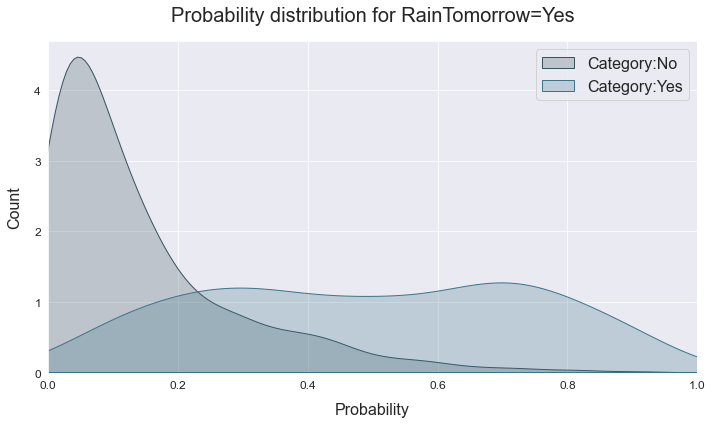

In [9]:
# The probabilties plot shows the distribution of predicted
# probabilities for the positive class
atom.winner.plot_probabilities()

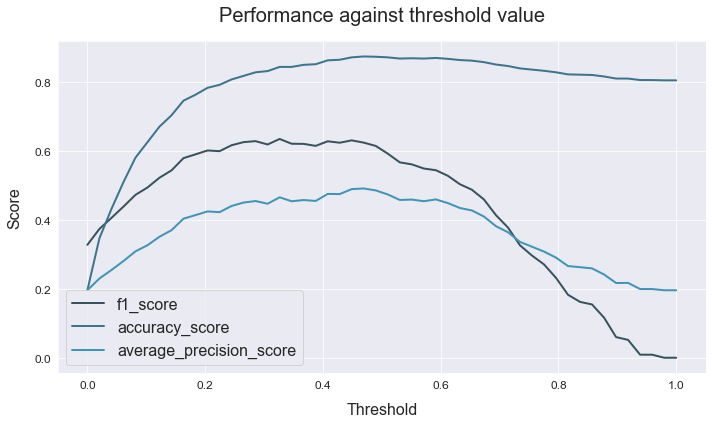

In [10]:
# The threshold plot let us compare how different metrics
# perform for different thresholds
atom.winner.plot_threshold(metric=['f1', 'accuracy', 'average_precision'], steps=50, filename='thresholds.png')

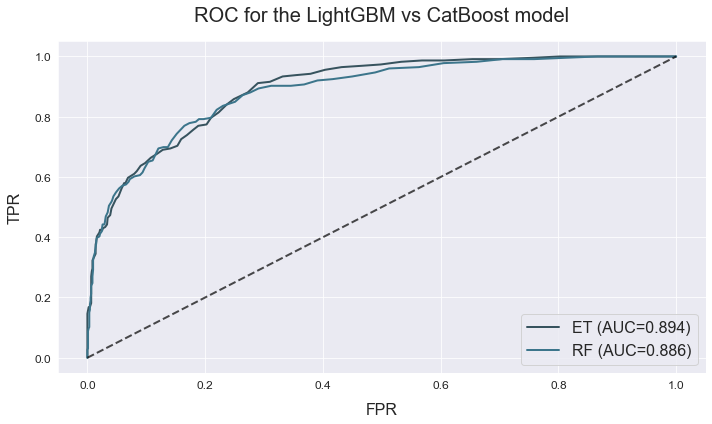

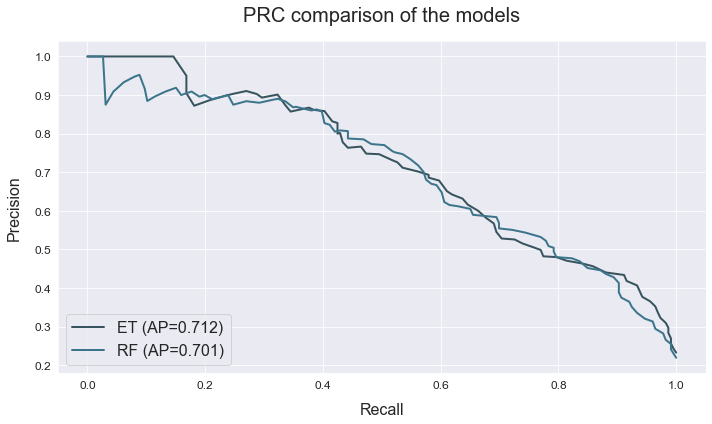

In [11]:
# The ROC and PRC curve are also typical ways of measuring performance 
atom.plot_roc(title="ROC for the LightGBM vs CatBoost model")
atom.plot_prc(title="PRC comparison of the models")